# Preprocessing
---

In [32]:
# Imports
import pandas as pd
import numpy as np
import re
from datetime import datetime

In [33]:
# Load Data
data = pd.read_csv('../data/raw/NY_SLI_CLEANED.csv', low_memory=False)

In [34]:
# Explore - List columns
data.columns.tolist()

['Service Line Locality',
 'Street Address',
 'Zip Code',
 'State',
 'Lead Gooseneck, Pigtail or Connector Currently Present',
 'Current Public Side SL Material',
 'Was Public SL Material Ever Previously Lead',
 'Public SL Material Verification Method',
 'Public SL Installation or Replacement Date',
 'Public SL Size',
 'Customer SL Material',
 'Customer SL Material Verification Method',
 'Lead Solder Present',
 'Building Type',
 'POU or POE Treatment Present',
 'Customer SL Installation or Replacement Date',
 'Customer SL Size',
 'SL Category',
 'Note',
 'Location',
 'Customer SL Material Category',
 'Public SL Material Verification Method Category',
 'Current SL Material Category',
 'Lead Connector Present Category',
 'Current Public Side SL Material Category',
 'Was Public SL Material Ever Previously Lead Category',
 'Public SL Installation Year',
 'Public SL Size Category',
 'Public SL Size Numeric',
 'SL Category Cleaned']

In [35]:
# Extract year from mixed date formats
def extract_year(value):
    if pd.isna(value):
        return None
    
    # Convert to string for processing
    value_str = str(value).strip()
    
    # Case 1: Already a 4-digit year
    if value_str.isdigit() and len(value_str) == 4:
        return int(value_str)

    # Case 3: YYYYMMDD format (8 digits)
    if value_str.isdigit() and len(value_str) == 8:
        try:
            year = int(value_str[:4])
            month = int(value_str[4:6])
            day = int(value_str[6:8])
            # Validate it's a reasonable date
            dt = datetime(year, month, day)
            if 1900 <= year <= 2100:
                return year
        except (ValueError, OSError):
            pass  # Not a valid YYYYMMDD, try other formats
    
    # Case 2: Unix timestamp (large integer, positive or negative)
    try:
        num = float(value_str)
        # Unix timestamps are typically 9-10 digits for recent dates
        if abs(num) > 10000000:  # Likely a timestamp
            dt = datetime.fromtimestamp(num)
            return dt.year
    except (ValueError, OSError):
        pass
    
    try:
        # Try parsing with pandas
        dt = pd.to_datetime(value_str, errors='coerce')
        if pd.notna(dt):
            return dt.year
    except:
        pass

    # Dash-separated or slash-separated dates 1999-2000, get first 4 digits
    year_range_match = re.match(r'^(\d{4})-(\d{2,4})$', value_str)
    if year_range_match:
        first_year = int(year_range_match.group(1))
        second_part = year_range_match.group(2)
        
        # If it's abbreviated (e.g., "76" or "77")
        if len(second_part) == 2:
            # Take the first year as the installation year
            return first_year
        else:
            # Full year provided (e.g., "1976-1977")
            return first_year

    
    # Regular Date Formats
    date_formats = [
        "%m/%d/%Y", "%m-%d-%Y", "%Y/%m/%d", "%Y-%m-%d",
        "%d/%m/%Y"
    ]
    for fmt in date_formats:
        try:
            dt = datetime.strptime(value_str, fmt)
            return dt.year
        except ValueError:
            continue
    
    return None  # If nothing works

# Drop empty rows in the date column
# list number of rows
data = data.dropna(subset=['Customer SL Installation or Replacement Date'])

# Drop unknown entries
data = data[~data['Customer SL Installation or Replacement Date'].isin(['Unknown', 'unknown', 'UNK', 'N/A', 'NA', '0'])]

# Filter out negative numbers
data = data[~data['Customer SL Installation or Replacement Date'].astype(str).str.startswith('-')]

# Apply to your dataframe
data['Customer SL Installation or Replacement Date'] = data['Customer SL Installation or Replacement Date'].apply(extract_year)

# Drop rows where year extraction failed
data = data.dropna(subset=['Customer SL Installation or Replacement Date'])
print("Final data shape after year installation fix:", data.shape[0])

Final data shape after year installation fix: 317490


### Location -> Latitude & Longitude

In [36]:
# Function to extract longitude and latitude from POINT string
def extract_coords(point_str):
    # Extract numbers from POINT (longitude latitude) format
    match = re.search(r'POINT \(([-\d.]+) ([-\d.]+)\)', str(point_str))
    if match:
        longitude = float(match.group(1))
        latitude = float(match.group(2))
        return pd.Series([latitude, longitude])
    return pd.Series([None, None])

# Apply extraction and create new columns
data[['Latitude', 'Longitude']] = data['Location'].apply(extract_coords)

# Drop the original Location column
data = data.drop('Location', axis=1)

# Drop rows where extraction failed
data = data.dropna(subset=['Latitude', 'Longitude'])

# Print final data shape
print("Final data shape after location fix:", data.shape[0])

# Save to CSV in data/processed
data.to_csv('../data/processed/NY_SLI_YEARS_EXTRACTED.csv', index=False)

Final data shape after location fix: 313193


**I saved a subset here that contains the data where we know for sure whether lead is/isnt present**

In [37]:
data_certain = data[data['SL Category Cleaned'] != "Unknown"]


## Experimenting with neighborhoods. 
* cleaned up the town/city name
* dropped cities with less than 50 entries
* plotted frequency
* sorted by frequency and saved to csv

HICKSVILLE: 12286
Elmira: 9083
HUNTINGTON STATION: 8144
Clay: 8021
NEW CITY: 6788
MELVILLE: 5500
Scarsdale: 5472
Cortland: 4720
Wappingers: 4172
FISHKILL: 3872
Cicero: 3809
PEARL RIVER: 3787
NANUET: 3730
Newburgh: 3372
ENDWELL: 3365
Manlius: 3318
Ballston: 3235
Ontario: 3143
Onondaga: 2950
Salina: 2910
Ithaca: 2678
Glens Falls: 2550
Gansevoort: 2534
Waterford: 2424
SPRING VALLEY: 2348
MONSEY: 2226
Lysander: 2162
CONGERS: 2102
Smithtown: 2037
Spring Valley: 2019
AIRMONT: 2003
HIGHLAND MILLS: 2000
DELMAR: 1991
Southport: 1966
VALLEY COTTAGE: 1946
Beacon: 1906
CHESTNUT RIDGE: 1885
Lansing: 1884
HUNTINGTON: 1826
Erwin: 1722
Camillus: 1721
STONY POINT: 1625
NEW ROCHELLE: 1620
TAPPAN: 1617
Saint James: 1602
RAMAPO: 1581
GLENMONT: 1507
HAVERSTRAW-THLLS: 1487
Kings Park: 1438
Big Flats: 1337
ORANGEBURG: 1266
WEST NYACK: 1259
WESTBURY: 1255
Geddes: 1213
ENDICOTT: 1182
Village of Elmira Heights: 1097
SELKIRK: 1070
Horseheads: 1044
ALBERTSON: 1039
SLINGERLANDS: 1032
GENEVA: 1013
Schaghticoke: 100

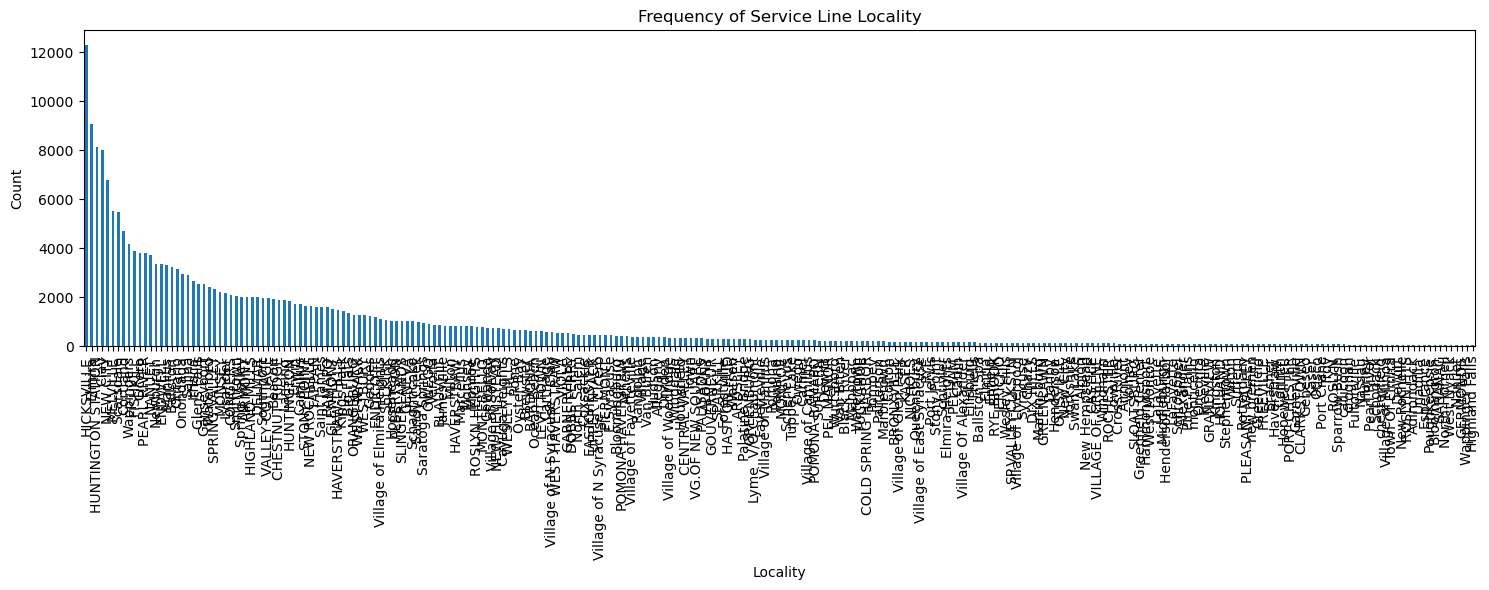

In [38]:
# Replace "Town of X" or "T of X" or "City of X" with just "X" in 'Service Line Locality'
data_certain.loc[:, 'Service Line Locality'] = data_certain['Service Line Locality'].str.replace(r'^(Town of |T of |City of |VG |V of )', '', regex=True).str.strip()

locality_counts = data_certain['Service Line Locality'].value_counts()


n = 50  # threshold to drop
localities_to_keep = locality_counts[locality_counts >= n].index
data_certain = data_certain[data_certain['Service Line Locality'].isin(localities_to_keep)]
locality_counts = data_certain['Service Line Locality'].value_counts()


for locality, count in locality_counts.items():
    print(f"{locality}: {count}")

import matplotlib.pyplot as plt

# Plot the frequency diagram (bar chart)
plt.figure(figsize=(15, 6))
locality_counts.plot(kind='bar')
plt.xlabel('Locality')
plt.ylabel('Count')
plt.title('Frequency of Service Line Locality')
plt.tight_layout()
plt.show()

# Reorder data_certain so that rows are sorted by the frequency of their 'Service Line Locality'
data_certain = data_certain.set_index('Service Line Locality').loc[locality_counts.index].reset_index()

data_certain.to_csv('../data/processed/NY_SLI_YEARS_ADJUSTED_NO_UNKNOWNS.csv', index=False)


In [39]:
len(data_certain)

223372